### Analysis of the DataSet

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import csv

### Preprocessing

In [18]:
def getSize(fileName):
    dataFrame = pd.read_csv(fileName,delimiter=',')
    traderList = list(dataFrame['Seller'])
    traderList.extend(list(dataFrame['Buyer']))
    traderSet = set(traderList)
    traderSize = len(traderSet)
    return traderSize

### Undirected Graph generation

In [19]:
# total transaction amount between them is the weight
def getUndirectedGraph(fileName):
#     K represents k nearest neighbors
    dataFrame = pd.read_csv(fileName, delimiter =',')
    nodeSize = getSize(fileName)
    myGraph = nx.Graph()
#     Added nodes to the Graph
    myGraph.add_nodes_from(list(range(1, nodeSize+1)))
#    Adding edges with weights to the Graph
    buyer = []
    seller = []
    trader = []
    for ind in dataFrame.index:
        u = dataFrame['Seller'][ind]
        v = dataFrame['Buyer'][ind]
        seller.append(u)
        buyer.append(v)
    
    vSeller = np.zeros(nodeSize+1)
    vBuyer = np.zeros(nodeSize+1)

    for x in seller:
        vSeller[x] =1 
    for x in buyer:
        vBuyer[x] = 1 

    for ind in dataFrame.index:
        u = dataFrame['Seller'][ind]
        v = dataFrame['Buyer'][ind]
        w = dataFrame['Amt'][ind]
        if (vSeller[u]==1) and (vBuyer[u]==1) and (vSeller[v]==1) and (vBuyer[v]==1) and(u!=v):
            trader.append(u)
            trader.append(v)
            if u in list(myGraph.adj[v]):
                myGraph[u][v]['weight']+=w
            else :
                myGraph.add_edge(u, v, weight = w)
    return (myGraph,list(set(trader)))

(undirectedGraph,nodeSet) = getUndirectedGraph('dataset.csv')

### Generating a undirected graph CSV 

In [43]:
nodeSize = getSize('dataset.csv')
undirectedDict = {}
for node in range(1, nodeSize+1):
    neighbors = undirectedGraph[node].items()
    neighborList = [x[0] for x in neighbors]
    undirectedDict[node] = neighborList
w = csv.writer(open("Undirected_Graph.csv", "w"))
for key, val in undirectedDict.items():
    w.writerow([key, val])

### Directed Graph generation

In [20]:
def getDirectedGraph(fileName):
    dataFrame = pd.read_csv(fileName, delimiter =',')
    nodeSize = getSize(fileName)
    myGraph = nx.DiGraph()
#     Added nodes to the Graph
    myGraph.add_nodes_from(list(range(1, nodeSize+1)))
#    Adding edges with weights to the Graph 
    for ind in dataFrame.index:
        u = dataFrame['Seller'][ind]
        v = dataFrame['Buyer'][ind]
        w = dataFrame['Amt'][ind]
        if u in list(myGraph.adj[v]):
            myGraph[v][u]['weight']+=w
        else :
            myGraph.add_edge(v, u, weight = w)
    return myGraph

DirectedGraph = getDirectedGraph('dataset.csv')

### Shared nearest neighbour Clustering Algorithm

### K-Nearest Neighbour

In [50]:
%%time
def kNear(graph, nodeSet, K):
    Dict = {}
    for node in nodeSet:
        neighbors = np.array(sorted(graph[node].items(), key=lambda e: e[1]["weight"], reverse=True))
        if(neighbors.shape[0]<K):
            neighborList = [x[0] for x in neighbors]
        else : 
            neighbors = neighbors[:K]
            neighborList = [x[0] for x in neighbors]
        Dict[node]=neighborList
    return Dict

knnGraph = kNear(undirectedGraph, nodeSet, 6)

CPU times: user 318 ms, sys: 15.4 ms, total: 333 ms
Wall time: 335 ms


### Union find algorithm

In [22]:
nodeSize = getSize('dataset.csv')
clusterId = np.array(list(range(nodeSize+1)))
clusterSize = np.ones(nodeSize, dtype = int)
def parent(u):
    while clusterId[u]!=u:
        u = clusterId[u]
    return u
def common(u, v):
    neighborU = knnGraph[u]
    neighborV = knnGraph[v]
    return len(list(set(neighborU)&set(neighborV)))
def union(u, v):
    x = parent(u)
    y = parent(v)
    global clusterId
    global clusterSize
    if clusterSize[x]>clusterSize[y]:
        clusterId[y] = x
        clusterSize[x]+=clusterSize[y]
    else :
        clusterId[x] = y 
        clusterSize[y]+=clusterSize[x]

### Shared Nearest Neighbor Algorithm

In [23]:
%%time
kt = 2
for u in nodeSet:
    for v in nodeSet:
        x = parent(u)
        y = parent(v)
        if x!= y :
            if (u in knnGraph[v]) and (v in knnGraph[u]):
                if common(u,v)>=kt:
                    union(u,v)

CPU times: user 1min 1s, sys: 60.2 ms, total: 1min 2s
Wall time: 1min 2s


### Final dictionary of Shared nearest neighbor

In [24]:
SNNClust = {}
vis = np.zeros(nodeSize+1, dtype = int)
for node in range(1, nodeSize+1):
    currId = parent(node)
    if vis[currId]==0:
        SNNClust[currId]=[node]
    else:
        SNNClust[currId].append(node)
    vis[currId] = 1
print(len(SNNClust))

32209


In [28]:
SNNDict = {}
for x in SNNClust:
    if len(SNNClust[x])>2:
        SNNDict[x]=SNNClust[x]

In [29]:
w = csv.writer(open("Shared_Nearest_Neighbor.csv", "w"))
for key, val in SNNDict.items():
    w.writerow([key, val])

### Visualisation of one cluster

### Creation of another graph

In [80]:
# get node list 
# add all the edges corresponding to it
# now whatever you are getting is the real list of nodes
# create a new graph
def virtualGraph(fileName, Dict):
    dataFrame = pd.read_csv(fileName, delimiter =',')
    nodeSize = getSize(fileName)
    vis = np.zeros(nodeSize+1, dtype= int)
    mark= np.zeros(nodeSize+1, dtype = int)
#     creation of virtual Graph
    vGraph = nx.DiGraph()
    vGraph.add_nodes_from(list(range(1, nodeSize+1)))
    nodeList = []
# adding nodes of the SNNDict
    for clusterId in Dict:
        for node in Dict[clusterId]:
            vis[node] = 1
            mark[node] = 1
#  adding nodes which have either of them visited
    cnt = 0 
    for ind in dataFrame.index:
        u = dataFrame['Seller'][ind]
        v = dataFrame['Buyer'][ind]
        w = dataFrame['Amt'][ind]
        if ((vis[u]==1) or (vis[v]==1)) and (cnt<800):
            if (mark[u]==0) or (mark[v]==0): 
                cnt+=1
            mark[u] = 1
            mark[v] = 1
            if u in list(vGraph.adj[v]):
                vGraph[v][u]['weight']+=w
            else :
                vGraph.add_edge(v, u, weight = w)
    for i in range(1, nodeSize+1):
        if mark[i]==0:
            vGraph.remove_node(i)
        else :
            nodeList.append(i)
    return (nodeList, vGraph)

In [81]:
(vNodeList, vGraph) = virtualGraph('dataset.csv', SNNDict)
print(len(vNodeList))

970


In [124]:
vdirectedDict = {}
for node in vNodeList:
    neighbors = vGraph[node].items()
    neighborList = [x[0] for x in neighbors]
    vdirectedDict[node] = neighborList
w = csv.writer(open("vdirected_Graph.csv", "w"))
for key, val in vdirectedDict.items():
    w.writerow([key, val])

### Mutual Nearest Neighbour

In [116]:
knnGraph = kNear(vGraph, vNodeList, 6)
DictofClusters = {}
for i in vNodeList:
    DictofClusters[i] = [i]

In [117]:
def mnvForNodes(u, v):
    listU = knnGraph[u]
    listV = knnGraph[v]
    rankOfVinU = 100
    rankOfUinV = 100
    
    for i in range(len(listU)):
        if listU[i]==v:
            rankOfVinU = i+1
            break
            
    for i in range(len(listV)):
        if listV[i]==u:
            rankOfUinV = i+1
            break

    return rankOfUinV+rankOfVinU

In [118]:
def mnvForClusters(c1, c2):
    cluster1 = DictofClusters[c1]
    cluster2 = DictofClusters[c2]
    s = 0
    for u in cluster1:
        for v in cluster2:
            val = mnvForNodes(u, v)
            s = s + val
    length = len(cluster1) * len(cluster2)
    return s/length

In [119]:
%%time
mnvSet = set([])
# for all pairs of clusters, find the mnv and insert into the set
for c1 in vNodeList:
    for c2 in vNodeList:
        if c1!=c2:
            currVal = mnvForClusters(c1, c2)
            mnvSet.add((currVal, c1, c2))

CPU times: user 3.02 s, sys: 32 ms, total: 3.05 s
Wall time: 3.09 s


In [120]:
%%time
def mutual_NN_neighbour(numofClusters, maxMNV):
    global DictofClusters
    global mnvSet
    totalClusters = len(DictofClusters)
#     keep iterating while you didn't get required number of clusters
    cnt = 0 
    while totalClusters>numofClusters:
        minCluster = min(mnvSet)
#     Breaking condition for MNV
        if minCluster[0]>maxMNV:
            break
        minU = minCluster[1]
        minV = minCluster[2]
        minNodes = [minU, minV]
#         remove all pairs which are either of minU,minV
        for c1 in DictofClusters:
            for node in minNodes:
                val = mnvForClusters(c1, node)
                pair1 = (val, c1, node)
                pair2 = (val, node, c1)
                if pair1 in mnvSet:
                    mnvSet.remove(pair1)
                if pair2 in mnvSet:
                    mnvSet.remove(pair2)
#       remove two clusters and combine them into one
        for v in DictofClusters[minV]:
            DictofClusters[minU].append(v)
        del DictofClusters[minV]
#         insert all the mnvs of the new clusters with the clusters existing
        for c1 in DictofClusters:
            if minU!=c1:
                currVal = mnvForClusters(c1, minU)
                mnvSet.add((currVal, c1, minU))
        print("Iteration ", cnt+1, "completed ", totalClusters, ",",numofClusters)
        cnt+=1
        totalClusters -=1
#         remove all the elements computing with c1, c2
# do the manipulations in the dictionary
# calculate the clustered one with every other cluster
# and push it into the set

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 15 µs


In [121]:
%%time
print(len(vNodeList))
mutual_NN_neighbour(len(vNodeList)-500, 160)

970
Iteration  1 completed  970 , 470
Iteration  2 completed  969 , 470
Iteration  3 completed  968 , 470
Iteration  4 completed  967 , 470
Iteration  5 completed  966 , 470
Iteration  6 completed  965 , 470
Iteration  7 completed  964 , 470
Iteration  8 completed  963 , 470
Iteration  9 completed  962 , 470
Iteration  10 completed  961 , 470
Iteration  11 completed  960 , 470
Iteration  12 completed  959 , 470
Iteration  13 completed  958 , 470
Iteration  14 completed  957 , 470
Iteration  15 completed  956 , 470
Iteration  16 completed  955 , 470
Iteration  17 completed  954 , 470
Iteration  18 completed  953 , 470
Iteration  19 completed  952 , 470
Iteration  20 completed  951 , 470
Iteration  21 completed  950 , 470
Iteration  22 completed  949 , 470
Iteration  23 completed  948 , 470
Iteration  24 completed  947 , 470
Iteration  25 completed  946 , 470
Iteration  26 completed  945 , 470
Iteration  27 completed  944 , 470
Iteration  28 completed  943 , 470
Iteration  29 completed  

In [123]:
Dict = {}
for x in DictofClusters:
    if len(DictofClusters[x])>2:
        Dict[x] = DictofClusters[x]
print(len(Dict))
w = csv.writer(open("Mutual_Nearest_Neighbor.csv", "w"))
for key, val in Dict.items():
    w.writerow([key, val])

21


### Drawing Graph with NetworkX

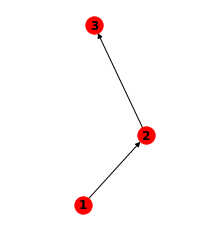

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()
G.add_edge(1,2, weight = 3.4)
G.add_edge(2,3, weight = 1.2)
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.savefig("SNN/path.png")